<span style="color:#26488F; font-size:30px; font-weight: bold;">  Predictive Maintenance Classification </span>

<html>
<body>
<div style="color:#435987;
            border-style: solid;
            border-radius: 25px;
            border-color: #435987;
            padding-left: 10px">
       
<span style="color:#26488F; font-size:20px; font-weight: bold;">  Brief Description </span><br>
    
This dataset reflects real predictive maintenance encountered in the industry with measurements from real equipment. The features description is taken directly from the dataset source. <br>    


<span style="font-weight: bold;"> The six features are: </span> <br>
<li>Type: the quality of the product, consisting of a letter L, M, or H. Meaning low, medium, and high, respectively. <br>
<li>Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.<br>
<li>Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature<br> plus 10 K.<br>
<li>Rotational speed [rpm]: calculated from power of 2860 W, overlaid with a normally distributed noise.<br>
<li>Torque [Nm]: torque values are normally distributed around 40 Nm with an Ïƒ = 10 Nm and no negative values.<br>
<li>Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.<br>
<br>

<span style="font-weight: bold;"> The targets are: </span> <br>
<li>Target: failure or no failure (to perform binary classification).<br>
<li>Failure Type: type of failure (to perform multiclass classification).<br>

<br>
It also includes the following information, which is not useful for building the models:<br>
<li>UID: unique identifier ranging from 1 to 10000.<br>
<li>ProductID: the id of the product.<br>
<br>

<span style="font-weight: bold;"> Dataset source: </span> https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification <br>
</p>
</div>

</body>
</html>

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Importing libraries </span> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier, EasyEnsembleClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler, NearMiss, ClusterCentroids
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve
import pickle
sns.set()

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Loading data and first impressions </span> 

In [2]:
raw_data = pd.read_csv('predictive_maintenance.csv')
df = raw_data.copy()
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


**Quick insights:** 
* There are 10.000 instances in the dataset
* The are no missing values (every feature has 10.000 observations)
* Target variable are ones and zeros
* UDI seems to be an index number
* Product ID is an identification number. Hence, it can be removed

In [4]:
# Checking unique values for 'UDI' and 'Product ID'
print(f"{df['UDI'].nunique()} unique values for 'UDI'")
print(f"{df['Product ID'].nunique()} unique value for 'Pruduct ID'")

10000 unique values for 'UDI'
10000 unique value for 'Pruduct ID'


In [5]:
# Dropping 'UDI' and 'Product ID' from the dataset
df.drop(['UDI', 'Product ID'], axis=1, inplace=True)

In [6]:
# Let's change the name of the columns.
df = df.rename(mapper={'Air temperature [K]': 'Air temperature',
                       'Process temperature [K]': 'Process temperature',
                       'Rotational speed [rpm]': 'Rotational speed',
                       'Torque [Nm]': 'Torque', 
                       'Tool wear [min]': 'Tool wear'}, axis=1)

In [7]:
# Taking a look at 'Failure Type' variable
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

This target variable assumes six possible values: no failure, or five different types of failure.


**Quick insight:** We can see that the dataset is highly unbalanced. Let's further check that with the 'target':


In [8]:
df['Target'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Target, dtype: float64



The dataset is indeed very unbalanced. We will deal with that later on.
 

In [9]:
# Rechecking for missing values
df.isna().sum()

Type                   0
Air temperature        0
Process temperature    0
Rotational speed       0
Torque                 0
Tool wear              0
Target                 0
Failure Type           0
dtype: int64

In [10]:
df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

'Type' assumes three possible values. Later on they will be hot or ordinal encoded.

In [11]:
# Taking a look at the data types
df.dtypes

Type                    object
Air temperature        float64
Process temperature    float64
Rotational speed         int64
Torque                 float64
Tool wear                int64
Target                   int64
Failure Type            object
dtype: object

'Type' and 'Failure Type' are type objects.

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Target variables </span>

There are two target variables: 'Target' and 'Failure Type'. Let's digg in a bit to check if everything is ok.

In [12]:
# Checking types of failure
df['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

There are 5 types of failure + not failure.

Now, let's check if there are inconsistencies between 'Target' and 'Failure Type': 


In [13]:
df_failure = df[df['Target'] == 1]
df_failure['Failure Type'].value_counts()

Heat Dissipation Failure    112
Power Failure                95
Overstrain Failure           78
Tool Wear Failure            45
No Failure                    9
Name: Failure Type, dtype: int64

**WARNING!!** 9 values are classified as failure in the 'Target' variable but as No Failure in the 'Failure Type' variable. Let's check in the dataset:

In [14]:
df_failure[df_failure['Failure Type'] == 'No Failure']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1437,H,298.8,309.9,1439,45.2,40,1,No Failure
2749,M,299.7,309.2,1685,28.9,179,1,No Failure
4044,M,301.9,310.9,1419,47.7,20,1,No Failure
4684,M,303.6,311.8,1421,44.8,101,1,No Failure
5536,M,302.3,311.8,1363,54.0,119,1,No Failure
5941,L,300.6,310.7,1438,48.5,78,1,No Failure
6478,L,300.5,309.8,1663,29.1,145,1,No Failure
8506,L,298.4,309.6,1710,27.3,163,1,No Failure
9015,L,297.2,308.1,1431,49.7,210,1,No Failure



It could go both ways, either failure or not failure. I think it would make sense to remove those instances since I do not know the real target here.


In [15]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'No Failure'].index
df.drop(index_possible_failure, axis=0, inplace=True)



Let's check the same but for 'Target' varibale equal to zero (no failure):
    

In [16]:
df_failure = df[df['Target'] == 0]
df_failure['Failure Type'].value_counts()

No Failure         9643
Random Failures      18
Name: Failure Type, dtype: int64

**Second warning!!** Similarly, we have 18 instances classifed as Random Failures by 'Failure Type', whereas they are classifed as Not failure by the 'Target Variable'. These 18 instances are in fact all instaces of 'Random Failures'.
Again, let's check and remove those instances as we do not really know if they belong to Failure or not. Hence, we will end up with 4 types of failures since 'Random Failures' will be removed altogether.

In [17]:
df_failure[df_failure['Failure Type'] == 'Random Failures']

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
1221,M,297.0,308.3,1399,46.4,132,0,Random Failures
1302,L,298.6,309.8,1505,45.7,144,0,Random Failures
1748,H,298.4,307.7,1626,31.1,166,0,Random Failures
2072,L,299.6,309.5,1570,35.5,189,0,Random Failures
2559,L,299.3,309.0,1447,50.4,140,0,Random Failures
3065,M,300.1,309.2,1687,27.7,95,0,Random Failures
3452,H,301.6,310.5,1602,32.3,2,0,Random Failures
5471,L,302.7,312.3,1346,61.2,170,0,Random Failures
5489,L,302.6,312.1,1499,35.0,215,0,Random Failures
5495,H,302.9,312.5,1357,55.0,12,0,Random Failures


In [18]:
index_possible_failure = df_failure[df_failure['Failure Type'] == 'Random Failures'].index
df.drop(index_possible_failure, axis=0, inplace=True)

27 instaces were removed (0.27% of the entire dataset). Of which:
   * 9 belonged to class **Failure in 'Target'** variable and **Not failure in target 'Failure Type'**
   * 18 belonged to class **Not failure in 'Target'** variable and **Random failures in target 'Failure Type'**

In [19]:
# We can check that all 27 instances were removed from the dataset:
df.shape[0]

9973

In [20]:
# Let's reset the index
df.reset_index(inplace=True, drop=True)

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Explanatory Data Analysis (EDA) </span>

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Correlation </span>

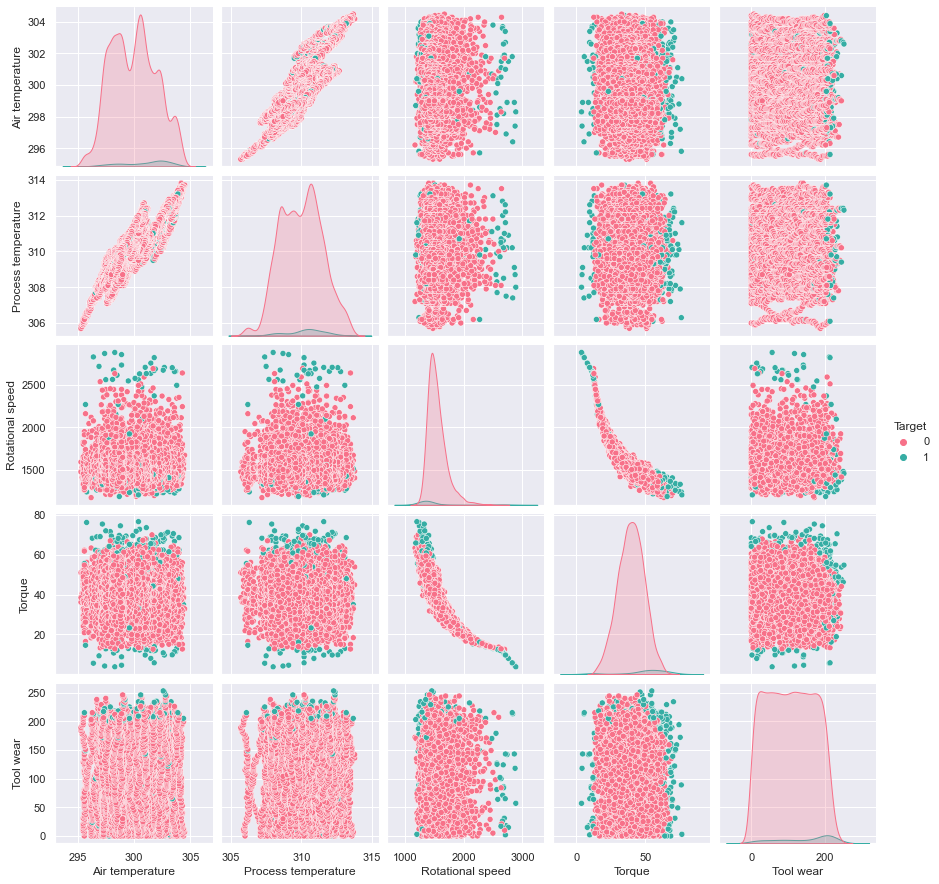

In [21]:
sns.pairplot(df, hue='Target', palette='husl')

**Insights:** 
* Torque and rotational speed are highly correlated.
* Process temperature and air temperature are also highly correlated.
* We immediately see that failures take place for extreme values of some features, i.e., the machinery fails either for the lowest or largest values of torque and rotational speed. This is easily spotted in the graph since the green dots are far apart for those features. So, there is a range for normal conditions in which the machines operate, and above or under this range, they tend to fail.

Let's plot a violin chart to see how torque and rotational speed behave:

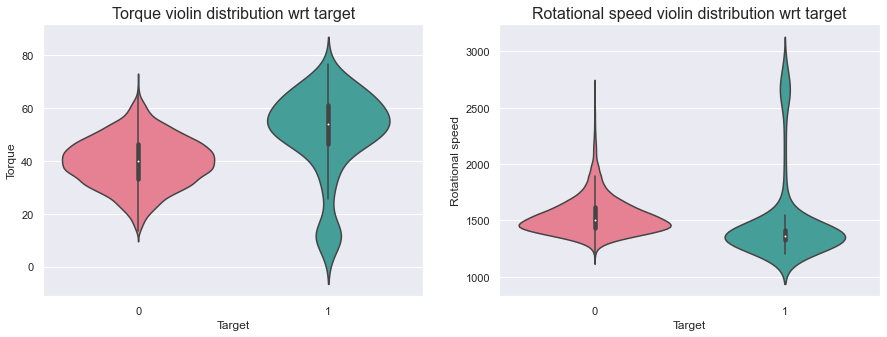

In [22]:
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16

fig, axes = plt.subplots(1, 2, figsize=[15,5])
axes = axes.flatten()
j=0

for i in ['Torque', 'Rotational speed']:
    sns.violinplot(data=df, x='Target', y=i, ax=axes[j], palette='husl')
    axes[j].set_title(i + ' violin distribution wrt target', )
    j += 1

**Insight:** Regarding torque and rotational speed, it can be seen again that most failures are triggered for much lower or much higher values than the mean when not feailing.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure </span>

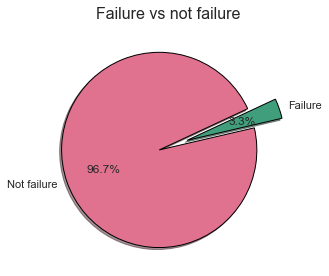

In [23]:
colors = ['#E1728F', '#409E7D'] 
plt.pie(df['Target'].value_counts(),  explode=[0.1, 0.2], labels=['Not failure', 'Failure'],
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
        colors=colors)
plt.title('Failure vs not failure')
plt.tight_layout()
plt.show()

**Insight:** as mentioned before, highly unbalanced dataset.

<span style="color:#26488F; font-size:22px; font-weight: bold;"> Correllation Heatmap </span>

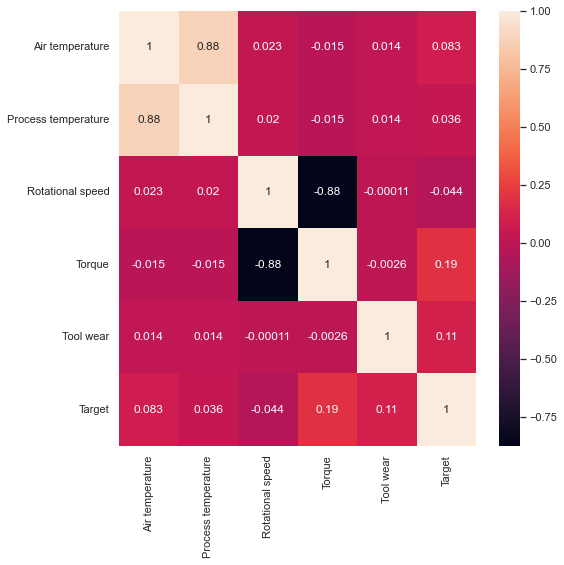

In [24]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

As mentioned before, there is high correlation between process temperature and air temperature, and between rotational speed and torque.


<span style="color:#26488F; font-size:22px; font-weight: bold;">  Product types </span>

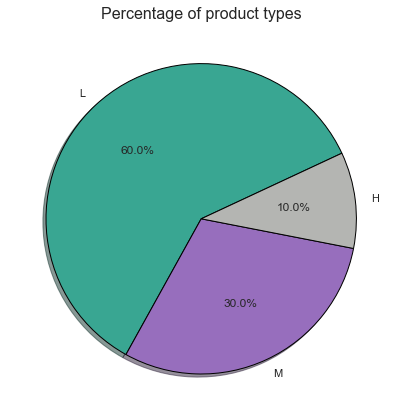

In [25]:
plt.rcParams["figure.figsize"] = (6,6)
colors = ['#39A692', '#976EBD', '#B4B5B2']
plt.pie(df['Type'].value_counts(), labels=['L', 'M', 'H'], colors=colors,
    autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)

plt.title('Percentage of product types')
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure wrt product type </span>

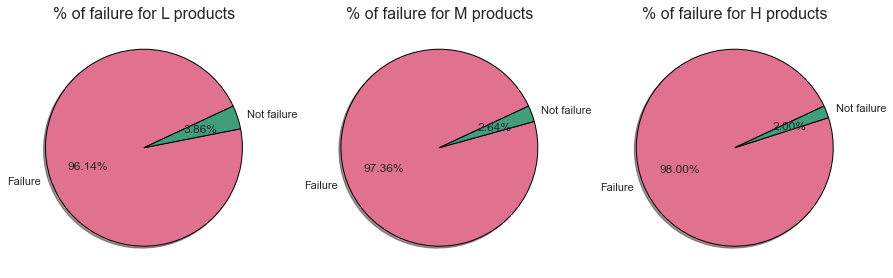

In [26]:
fig, axes = plt.subplots(1,3, figsize=[15,5])
axes.flatten()
j=0
colors = ['#E1728F', '#409E7D'] 
for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    axes[j].pie(df_product_type['Target'].value_counts(), labels=['Failure', 'Not failure'],
                autopct='%1.2f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25,
                colors=colors)
    axes[j].set_title('% of failure for ' + i + ' products')
    j+=1

**Insight:** L products have a higher ratio of failure compared to the other product types. Moreover, M tends to fail more than H products.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Percentage of failure types </span>

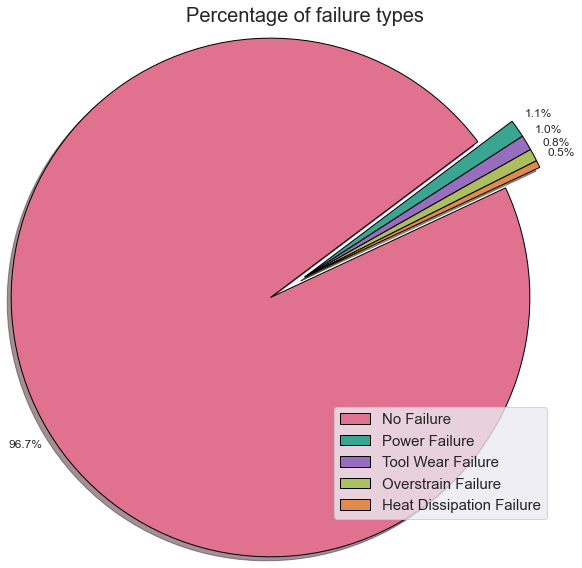

In [27]:
columns_failure_type = df['Failure Type'].unique().tolist()  # Types of failures

plt.rcParams["figure.figsize"] = (8,8)
colors = ['#E1728F', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E']

plt.pie(df['Failure Type'].value_counts(), explode=(0.2, 0, 0, 0, 0), autopct='%1.1f%%',
        wedgeprops={'edgecolor': 'black'}, counterclock=False, shadow=True, startangle=25,
        pctdistance=1.1, radius=1.3, colors=colors)
plt.legend(columns_failure_type, loc='lower right', fontsize=15)

plt.title('Percentage of failure types', fontsize=20)
plt.tight_layout()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Exploring features for each type of failure </span>

Text(0.5, 1.0, 'Excluding class no failure')

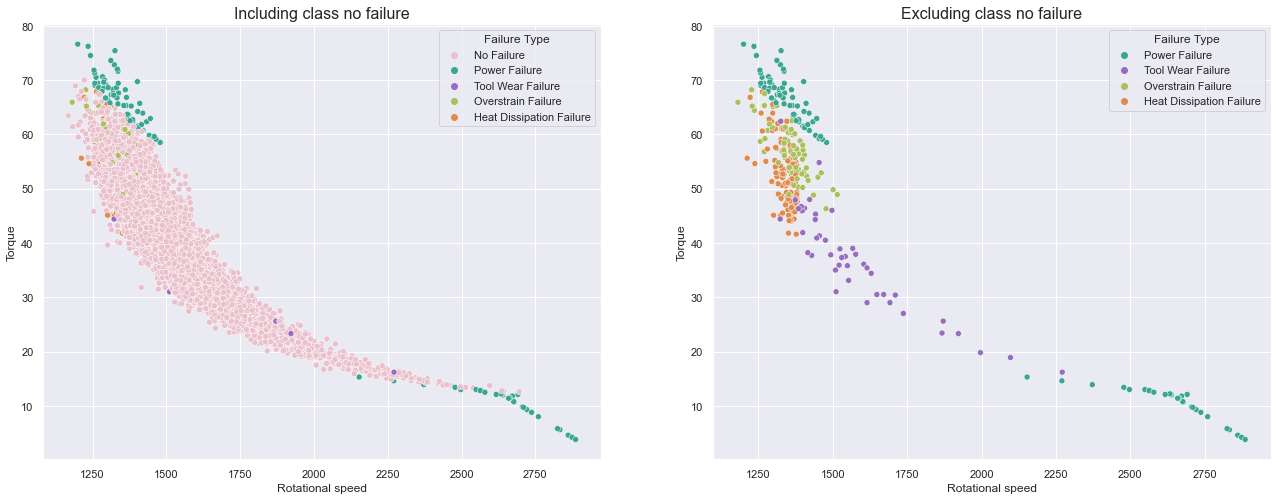

In [28]:
fig, ax = plt.subplots(1,2, figsize=[22,8])
plt.title('Rot. Speed vs Torque wrt Failure Type')
sns.scatterplot(data=df, x='Rotational speed', y='Torque', hue='Failure Type', palette=['#E9C0CB', '#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[0])
sns.scatterplot(data=df[df['Target'] == 1], x='Rotational speed', y='Torque', hue='Failure Type', palette=['#39A692', '#976EBD', '#ACBF5C', '#DF8B4E'], ax=ax[1])

ax[0].set_title('Including class no failure')
ax[1].set_title('Excluding class no failure')

**Some insights:**
* Power failure happens both for lower and higher rotational speed/torque. It is the type of failure with the highest rotational speed (over 2500rpm) and lowest torque (below around 15Nm). In other others, above and below these thresholds  only power failures occur. 
* Between torques 16Nm and 41Nm all failures are tool wear. 
* Overstrain failures take place with torques ranging from around 47 and 68Nm) and rotational speeds from 1200 to 1500rpm approximately.
* For heat dissipation failures, the torque range is smalller and the rotational speed range is bigger, compared to overstrain failures.



<span style="color:#26488F; font-size:22px; font-weight: bold;">  Distribution </span> 

----- SKEWNESS ------------
Air temperature skewness = 0.12
Process temperature skewness = 0.02
Rotational speed skewness = 1.99
Torque skewness = -0.01
Tool wear skewness = 0.03
---------------------------


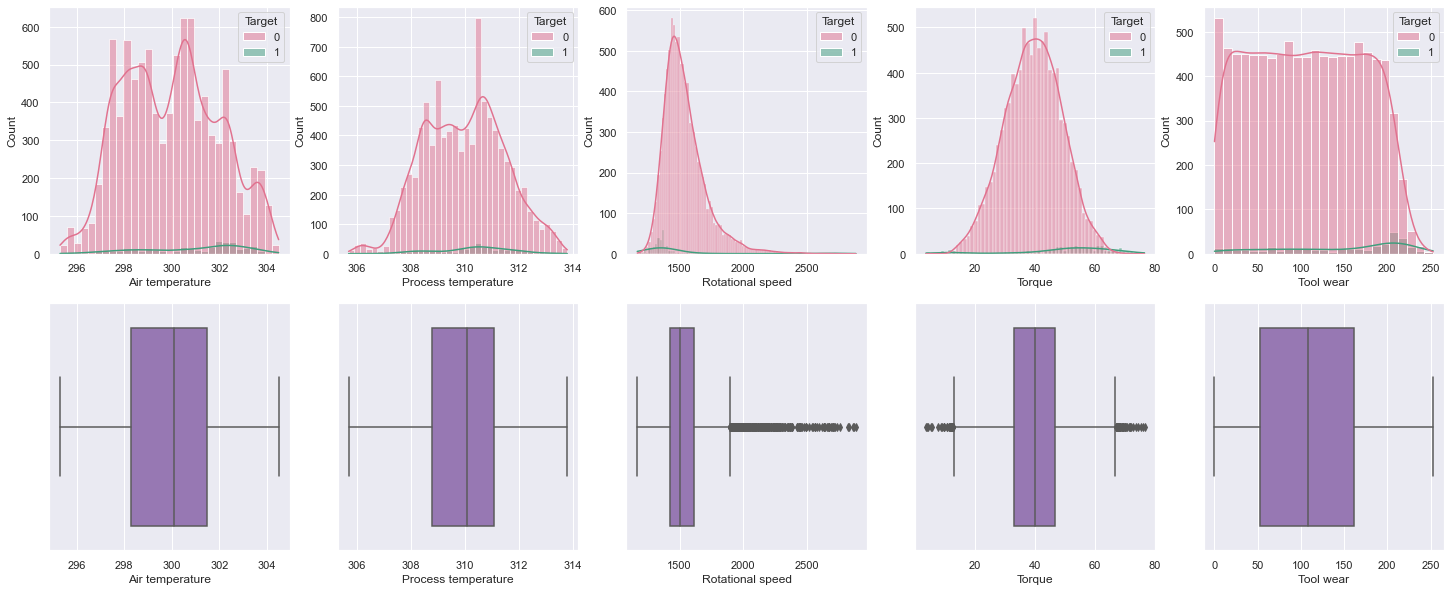

In [29]:
print('----- SKEWNESS ------------')
fig, axes = plt.subplots(2, 5, figsize=[25,10])
j = 0
colors = ['#E1728F', '#409E7D']

for i in ['Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear']:
    sns.histplot(data=df, x=i, kde=True, ax=axes[0,j], hue='Target', palette=colors)
    sns.boxplot(data=df, x=i, ax=axes[1,j], palette=['#976EBD'])
    j+=1
    print('{} skewness = {}'.format(i, round(df[i].skew(), 2)))
print('---------------------------')

* Rotational speed is positively skewed.
* From the boxplots we can see that 'Rotational speed' and 'Torque' have outliers.

Let's check those potential 'outliers' by analyzing the boxplots:


In [30]:
# Function to calculate the maximum and minumum value from the boxplot
def maximum_box(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    maximum = Q3 + 1.5*IQR
    minimum = Q1 - 1.5*IQR
    return maximum, minimum

for i in ['L', 'M', 'H']:
    df_product_type = df[df['Type'] == i]
    max_rotational_speed, min_rotational_speed = maximum_box(df_product_type['Rotational speed'])
    max_torque, min_torque = maximum_box(df_product_type['Torque'])
    print('Values from boxplot for type product ' + i + ':')
    print(f'Maximum torque value: {round(max_torque,2)}')
    print(f'Minimum torque value: {round(min_torque,2)}')
    print(f'Maximum rotational speed value: {round(max_rotational_speed,2)}')
    print(f'Minimum rotational speed value: {round(min_rotational_speed,2)}')
    print('='*20)

Values from boxplot for type product L:
Maximum torque value: 67.2
Minimum torque value: 12.8
Maximum rotational speed value: 1894.0
Minimum rotational speed value: 1142.0
Values from boxplot for type product M:
Maximum torque value: 67.05
Minimum torque value: 13.05
Maximum rotational speed value: 1895.75
Minimum rotational speed value: 1137.75
Values from boxplot for type product H:
Maximum torque value: 66.96
Minimum torque value: 12.66
Maximum rotational speed value: 1894.38
Minimum rotational speed value: 1143.38


**Insight:** The operational range for torque and rotational speed are similar for all product types.

Values above the maximum and below the minimum might be outliers, but not necessarily. 

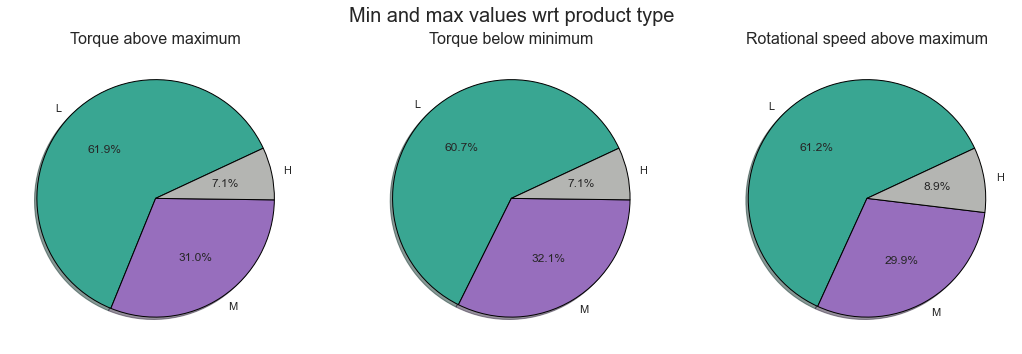

In [31]:
max_rotational_speed, min_rotational_speed = maximum_box(df['Rotational speed'])
max_torque, min_torque = maximum_box(df['Torque'])

max_torque_values = df[df['Torque'] >= max_torque]['Type'].value_counts()  # Torque values above the boxplot maximum
min_torque_values = df[df['Torque'] <= min_torque]['Type'].value_counts()  # Torque values below the boxplot minimum
max_rotational_speed_values = df[df['Rotational speed'] >= max_rotational_speed]['Type'].value_counts()  # Rotational spede values above the boxplot maximum

fig, axes = plt.subplots(1,3, figsize=[15,5])
fig.suptitle('Min and max values wrt product type', fontsize=20)
plt.rcParams['axes.titlesize'] = 16
axes.flatten()
j=0
colors = ['#39A692', '#976EBD', '#B4B5B2']

for i in [max_torque_values, min_torque_values, max_rotational_speed_values]:
    axes[j].pie(i, labels=['L', 'M', 'H'], colors=colors,
        autopct='%1.1f%%', wedgeprops={'edgecolor': 'black'}, shadow=True, startangle=25)
    j+=1

axes[0].set_title('Torque above maximum')
axes[1].set_title('Torque below minimum')
axes[2].set_title('Rotational speed above maximum')
plt.tight_layout()

**Insight:** The values above the maximum and below the minimum are not high correlated with the product type. The proportion of the pies are similar to the 60-30-10 proportion of the entire dataset.

However, there are proportionally slightly more values for L products and less for H across the three scenarios.

In [32]:
total_max_min_values = max_torque_values.sum() + min_torque_values.sum() + max_rotational_speed_values.sum()  # Total of instance under and above the minimum and maximum threshold from the boxplot, respectively.
ratio = total_max_min_values/df.shape[0]  # Percetange of these values with respect to the entire dataset
print('Percentage of values under and above the minimum and maximum threshold from the boxplot: {}'.format(ratio))

Percentage of values under and above the minimum and maximum threshold from the boxplot: 0.048932116715130855


**Insight:** 4.87% of the instances could be considered as ouliers using the boxplot method.

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Data Preprocessing </span>

In [33]:
columns_failure_type = df['Failure Type'].unique().tolist()

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Ordinal Encoding </span>

In [34]:
# Pass on the categorical values
ord_enc = OrdinalEncoder(categories=[['L', 'M', 'H'], columns_failure_type])

# Fit and transform the data for feature 'Type' and target 'Failure Type'
new_dat = ord_enc.fit_transform(df[['Type', 'Failure Type']])
new_dat
df.drop(['Type', 'Failure Type'], axis=1, inplace=True)

new_df = pd.DataFrame(new_dat, 
                      index=df.index, 
                      columns=['Type', 'Failure Type'])

df = pd.concat([df, new_df], axis=1)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Scaling data </span>

Since 'Rotational spede' and 'Torque' have outliers, I am going to use RobustScaler:

In [35]:
df_scaled = df.copy()

# Scaling Rotational speed and torque with robust scaler:
columns = ['Rotational speed', 'Torque']
scaler = RobustScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled,features_scaled], axis=1)

df_scaled.head(5)

,Air temperature,Process temperature,Tool wear,Target,Type,Failure Type,Rotational speed,Torque
0,298.1,308.6,0,0,1.0,0.0,0.253968,0.200000
1,298.2,308.7,3,0,0.0,0.0,-0.502646,0.459259
2,298.1,308.5,5,0,0.0,0.0,-0.026455,0.688889
3,298.2,308.6,7,0,0.0,0.0,-0.370370,-0.044444
4,298.2,308.7,9,0,0.0,0.0,-0.502646,-0.007407


The rest of the features will be MinMax scaling:

In [36]:
columns = ['Air temperature', 'Process temperature', 'Tool wear']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled = pd.concat([df_scaled, features_scaled], axis=1)

df_scaled.head()

,Target,Type,Failure Type,Rotational speed,Torque,Air temperature,Process temperature,Tool wear
0,0,1.0,0.0,0.253968,0.200000,0.304348,0.358025,0.000000
1,0,0.0,0.0,-0.502646,0.459259,0.315217,0.370370,0.011858
2,0,0.0,0.0,-0.026455,0.688889,0.304348,0.345679,0.019763
3,0,0.0,0.0,-0.370370,-0.044444,0.315217,0.358025,0.027668
4,0,0.0,0.0,-0.502646,-0.007407,0.315217,0.370370,0.035573


<span style="color:#26488F; font-size:28px; font-weight: bold;">  Modeling with 'Target' variable </span>

As the dataset is unbalanced, I am going to used ROC AUC score to assess model performance.

First, let's build a model with 'Target Variable'. Hence, we need to remove the other target 'Failure Type' to avoid data leakage.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Stratified Split </span>

In [37]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Target']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Target'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0    0.966911
1    0.033089
Name: Target, dtype: float64
Target proportion in y_train dataset:
0    0.966974
1    0.033026
Name: Target, dtype: float64
Target proportion in y_test dataset:
0    0.96672
1    0.03328
Name: Target, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Balanced Models </span>

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
Cross validation roc auc: 0.9762
ROC AUC test set: 0.9253

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
Cross validation roc auc: 0.9778
ROC AUC test set: 0.933

Fitting RUSBoostClassifier(random_state=42)
Cross validation roc auc: 0.8496
ROC AUC test set: 0.6933

Fitting EasyEnsembleClassifier(random_state=42)
Cross validation roc auc: 0.9625
ROC AUC test set: 0.9087



Text(0.5, 1.0, 'Easy Ensemble')

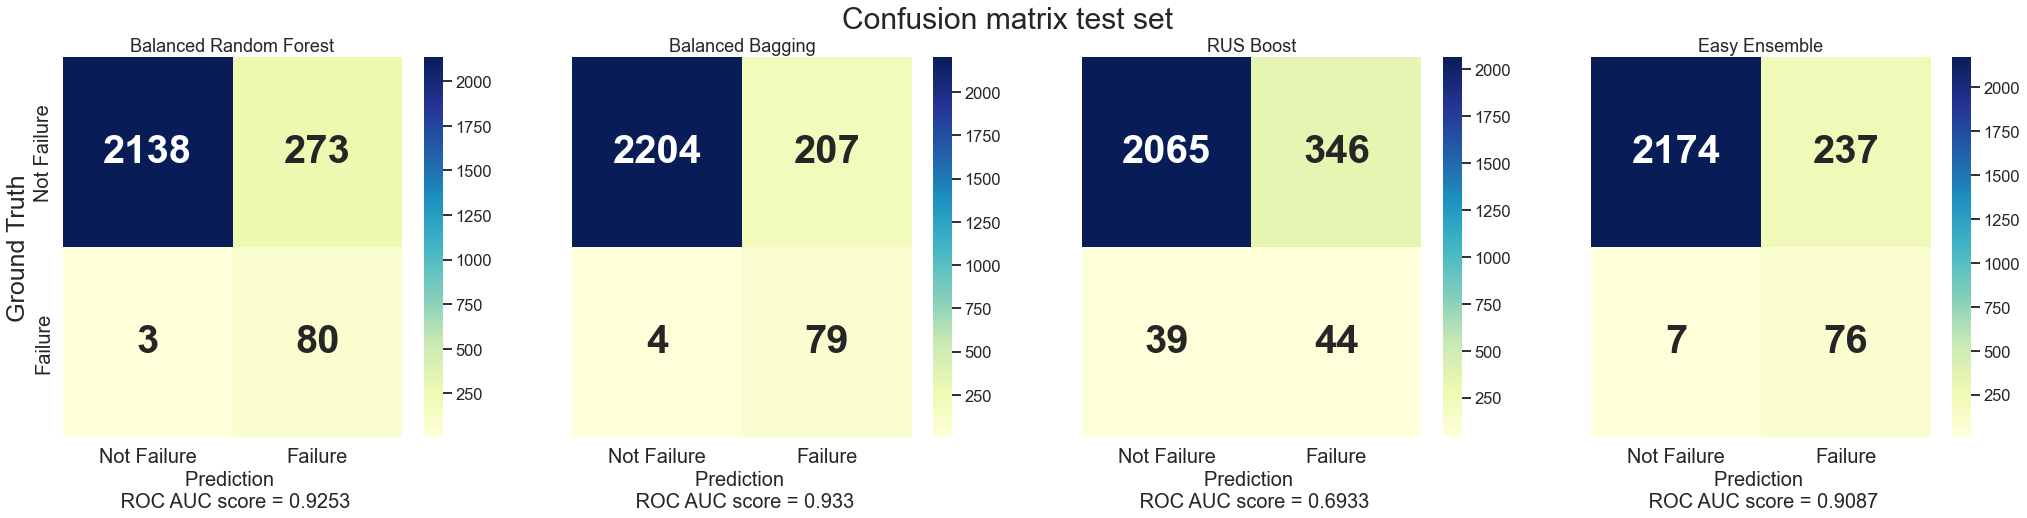

In [38]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

fig, axes = plt.subplots(1, 4, figsize=[35,7])
fig.suptitle('Confusion matrix test set', fontsize=30)
axes.flatten()
j=0
for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
    print(f'Cross validation roc auc: {round(cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring="roc_auc").mean(),4)}')
    
    y_pred = model.predict(X_test)
    print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred),4)}')
    print()
    
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=axes[j])

    labels = ['Not Failure', 'Failure']
    axes[j].set_xticklabels(labels, fontsize=20)
    axes[j].set_yticklabels(['',''], fontsize=20)
    axes[j].set_xlabel('Prediction \n ROC AUC score = ' + str(round(roc_auc_score(y_test, y_pred),4)), fontsize=20)
    j += 1

axes[0].set_yticklabels(labels, fontsize=20)
axes[0].set_ylabel('Ground Truth', fontsize=25)
axes[0].set_title('Balanced Random Forest')
axes[1].set_title('Balanced Bagging')
axes[2].set_title('RUS Boost')
axes[3].set_title('Easy Ensemble')

Balanced Random Forest and Balanced Bagging have the best performance of all four models with an **ROC AUC** score of **0.9253** and **0.933** in the test set, respectively.

However, first let's try using different sampling techniques to see if we achieve better performance or not.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Random Forest with different over and undersampling methods (Random Search) </span>

In [39]:
RdFo = RandomForestClassifier(random_state=42, criterion='entropy')

OverSamp_1 = RandomOverSampler(random_state=42)
OverSamp_2 = SMOTE(random_state=42, n_jobs=-1)
OverSamp_3 = BorderlineSMOTE(random_state=42, n_jobs=-1)
OverSamp_4 = ClusterCentroids(random_state=42)
OverSamp_5 = TomekLinks(n_jobs=-1)
OverSamp_6 = NearMiss(version=3, n_jobs=-1)

results_df = pd.DataFrame()

OverSamp_list = [OverSamp_1, OverSamp_2, OverSamp_3, OverSamp_4, OverSamp_5, OverSamp_6]

for samp in OverSamp_list:
    X_train_resampled, y_train_resampled = samp.fit_resample(X_train, y_train)
    
    grid_param = {'n_estimators': np.arange(10, 160,10),
                   'max_depth': np.arange(10, 110, 10),
                   'min_samples_split': [2, 5, 10]}

    random_search = RandomizedSearchCV(RdFo, grid_param, cv=3, n_jobs=-1, scoring='roc_auc', random_state=42)
    random_search.fit(X_train_resampled, y_train_resampled)
    y_pred = random_search.predict(X_test)
    score_df = pd.DataFrame({'accuracy': accuracy_score(y_test, y_pred),
                         'precision': precision_score(y_test, y_pred),
                         'recall': recall_score(y_test, y_pred),
                         'f1': f1_score(y_test, y_pred),
                         'auc': roc_auc_score(y_test, y_pred)},
                         index=[str(samp).split('(')[0]])
    
    params_df = pd.DataFrame(random_search.best_params_, index=[str(samp).split('(')[0]])
    params_df = pd.concat([params_df, score_df], axis=1)
    results_df = pd.concat([results_df, params_df])

results_df.round(2)

,n_estimators,min_samples_split,max_depth,accuracy,precision,recall,f1,auc
RandomOverSampler,30,2,100,0.99,0.88,0.70,0.78,0.85
SMOTE,110,2,100,0.97,0.58,0.83,0.68,0.91
BorderlineSMOTE,110,2,100,0.98,0.60,0.80,0.68,0.89
ClusterCentroids,130,5,30,0.05,0.03,1.00,0.07,0.51
TomekLinks,130,10,100,0.99,0.93,0.67,0.78,0.84
NearMiss,130,5,30,0.93,0.30,0.81,0.44,0.87


SMOTE oversampling had the best performace with an **AUC ROC** score equal to **0.91** and a f1 score of **0.68**.in the test dataset. 
    
Nonetheless, the result is lower than those of Balanced Random Forest and Balanced Bagging
Hence, I am going to use the balanced algorithms from now on.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Tuning Balanced Random Forest & Balanced Bagging </span>

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Randomized Search Balanced Random Forest </span>

In [40]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': np.arange(150, 400, 50),
               'max_depth': np.arange(10, 50, 10),
               'min_samples_split': [2, 4, 6],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': ['sqrt', 'log2']
            }

random_search = RandomizedSearchCV(brfc, params, scoring='roc_auc', cv=3,
                                   n_iter=100, random_state=42, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

In [41]:
# Best parameters from random search
print(random_search.best_params_)

# Roc auc score on test set
y_pred = random_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred),4)}')

{'n_estimators': 350, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}
ROC AUC test set: 0.933


<span style="color:#26488F; font-size:18px; font-weight: bold;">  Grid Search Balanced Random Forest </span>

In [42]:
brfc = BalancedRandomForestClassifier(criterion='entropy', min_samples_split=4, max_features='log2', 
                                      random_state=42, n_jobs=-1)

params = {'n_estimators': [300, 350, 400],
               'max_depth': [35, 40, 45],
               'min_samples_leaf': [1, 2]
            }

grid_search = GridSearchCV(brfc, params, scoring='roc_auc', cv=cv,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)

In [43]:
# Best parameters from grid search
print(f'Best parameters: {grid_search.best_params_}')

# Roc auc score on test set
y_pred_brfc = grid_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_brfc),4)}')

Best parameters: {'max_depth': 35, 'min_samples_leaf': 1, 'n_estimators': 300}
ROC AUC test set: 0.9313


**Result Balanced Random Forest:** The **roc auc score** in the test set increased from **0.9253** to **0.9313**.

Let's now optimize Balanced Bagging:

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Grid Search Balanced Bagging </span>

In [44]:
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': range(5,20),
         }
random_search = GridSearchCV(bbc, params, scoring='roc_auc', cv=3,
                             n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

In [45]:
# Best parameters from random search
print(random_search.best_params_)

# Roc auc score on test set
y_pred_bbc = random_search.predict(X_test)
print(f'ROC AUC test set: {round(roc_auc_score(y_test, y_pred_bbc),4)}')

{'n_estimators': 19}
ROC AUC test set: 0.9392


**Result Balanced Bagging:** The **roc auc score** in the test set increased from **0.9330** to **0.9392**.


Let's print out the classification report for both models:

In [46]:
print('Classification report Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('='*53)

print('Classification report Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))

Classification report Balanced Random Forest
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      2411
           1       0.23      0.98      0.37        83

    accuracy                           0.89      2494
   macro avg       0.61      0.93      0.66      2494
weighted avg       0.97      0.89      0.92      2494

Classification report Balanced Bagging
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2411
           1       0.28      0.96      0.43        83

    accuracy                           0.92      2494
   macro avg       0.64      0.94      0.69      2494
weighted avg       0.97      0.92      0.94      2494



**Results**: 
* ROC AUC is higher for Balanced Bagging.
* Macro and weighted f1 score average are higher for Balanced Bagging.
* Only the recall score is a bit higher for Balanced Random Forest at 0.98 compared to 0.96 for Balanced Bagging. However, this score can be increased decreasing the decision threshold in the probability prediction.

**Balanced Bagging Classifier is selected.**

Let's train the model with those hyperparameters:

In [47]:
bbc = BalancedBaggingClassifier(n_estimators=19, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred = bbc.predict(X_test)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Confusion matrix </span>

Text(0.5, 40.5, 'Prediction')

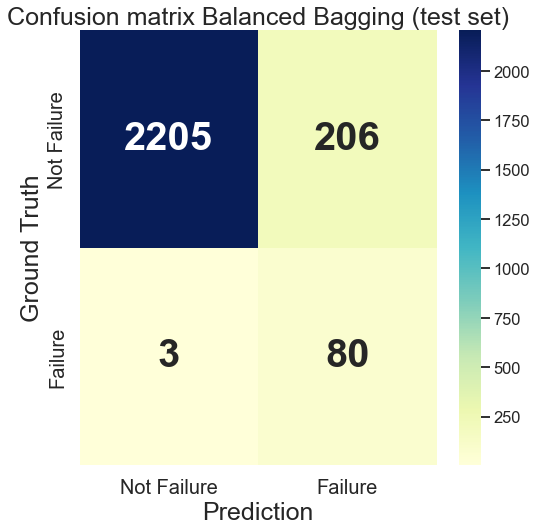

In [48]:
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
plt.title('Confusion matrix Balanced Bagging (test set)', fontsize=25)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"})

labels = ['Not Failure', 'Failure']
ax.set_xticklabels(labels, fontsize=20);
ax.set_yticklabels(labels, fontsize=20);
ax.set_ylabel('Ground Truth', fontsize=25);
ax.set_xlabel('Prediction', fontsize=25)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  ROC and Precision-Recall curves </span>

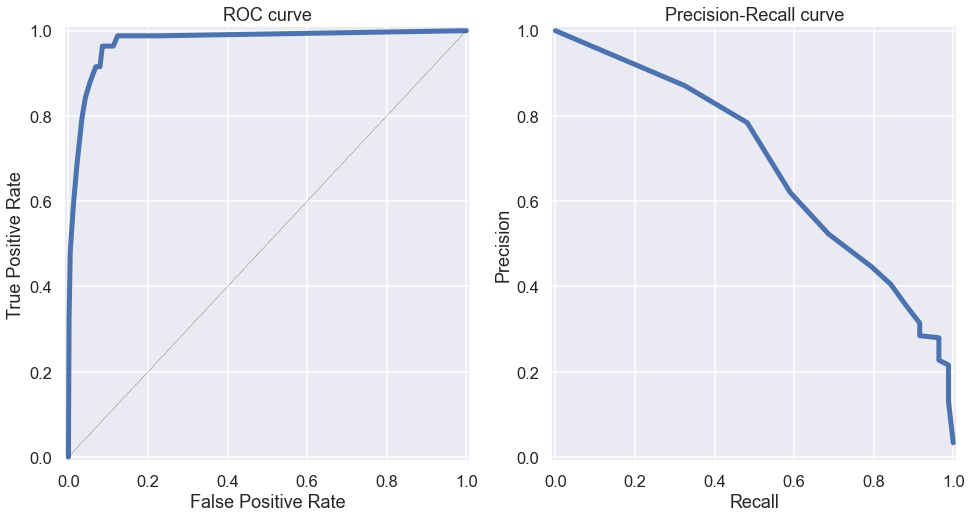

In [49]:
fig.set_size_inches(16, 8)
fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

y_prob = bbc.predict_proba(X_test)

# ROC-AUC curve
ax = axList[0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr, linewidth=5)
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Precision-recall curve
ax = axList[1]
precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Precision-Recall wrt decision threshold </span>

In [50]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      2411
           1       0.28      0.96      0.43        83

    accuracy                           0.92      2494
   macro avg       0.64      0.94      0.69      2494
weighted avg       0.97      0.92      0.94      2494



For the minority class (failure) we obtain a recall of 0.96 and a precision of 0.28. The algorithm classifies using a threshold of 0.5, meaning that if the probability of a certain instance of being class 1 (failure) is 0.51, it will be classied as failure. On the other hand, if it is less than 0.5 it will be classify as not failure.

We can change this threshold to obtain higher recall or precision scores, depending on what we are trying to achieve. For instace, setting a decision threshold at 0.6 would decrease recall and increase precision, and viceversa.

In the curve below, we can see the trade off between recall and precision by changing the decision threshold.

Text(0.39, -0.04, '0.5 threshold')

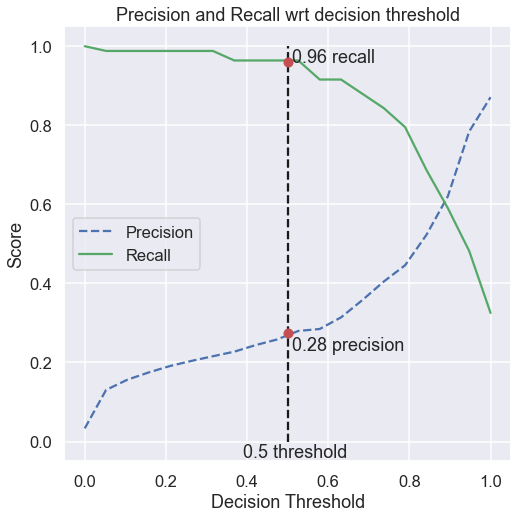

In [51]:
# from sklearn.metrics import plot_precision_recall_curve
y_pred = bbc.predict_proba(X_test)[:,1]
p, r, threshold = precision_recall_curve(y_test, y_pred)

def plot_precision_recall_threshold(precisions, recalls, thresholds):

    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall wrt decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot([0.5, 0.5], [0, 1], 'k--')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='center left')
    
plot_precision_recall_threshold(p, r, threshold)
# Precision score at 0.5 threshold
plt.plot(0.5, 0.275, 'or')
plt.annotate('0.28 precision', (0.51, 0.23))
# Recall score at 0.5 threshold
plt.plot(0.5, 0.96, 'or')
plt.annotate('0.96 recall', (0.51, 0.96))
plt.annotate('0.5 threshold', (0.39, -0.04))

With a default 0.5 threshold, we obtain a 0.96 recall and 0.28 precision score, just as seen in the classification report above. We can move the decision threshold to achieve a desired trade-off of precision-recall.

Since we are trying to predic machine failure, the minority class (class failure) should be more important. Hence, we aim at higher recall at the expense of lower precision. It is better to have some false positive than not predicting a failure.

[Text(0, 0.5, 'Not Failure'), Text(0, 1.5, 'Failure')]

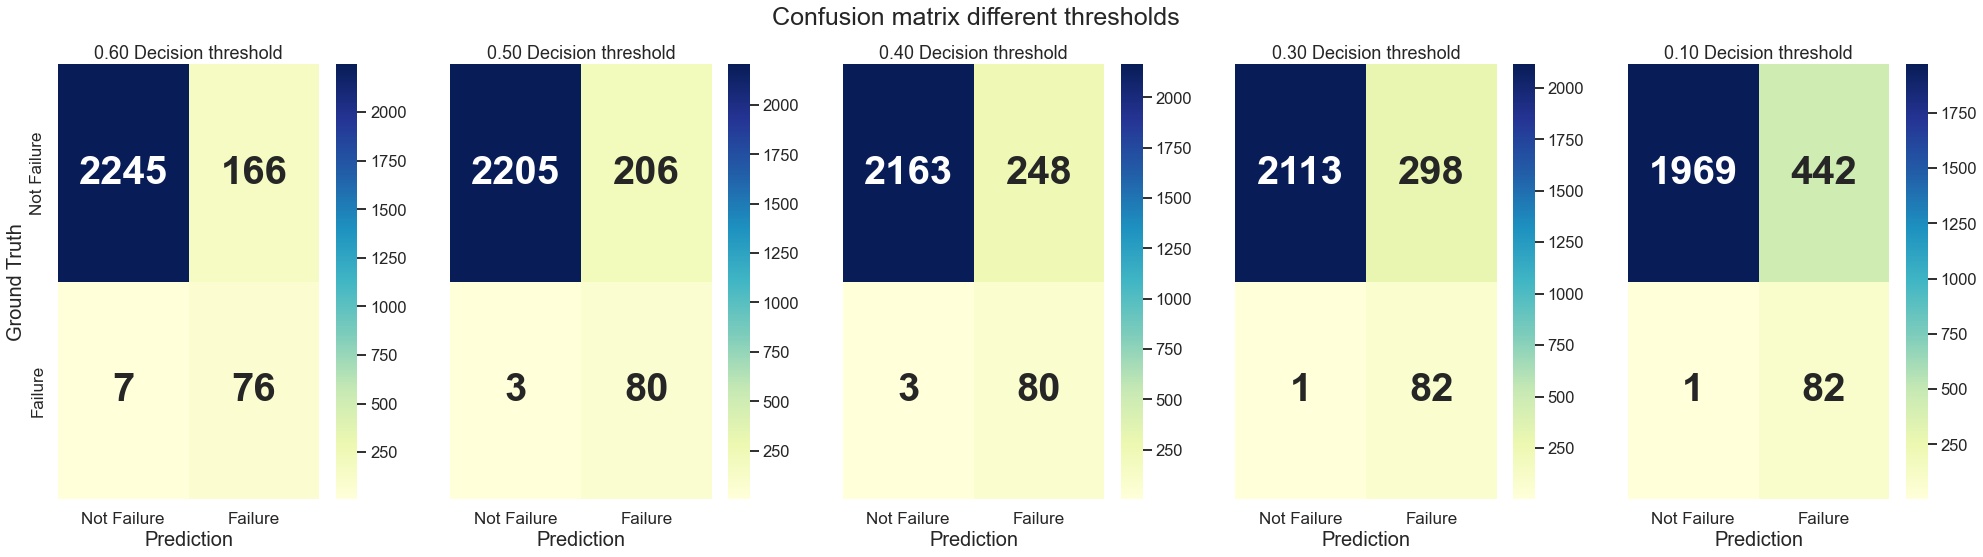

In [52]:
# Prediction probabilities with different thresholds
y_pred_dt = (bbc.predict_proba(X_test)[:,1] >= 0.1).astype(bool).astype(int)
y_pred_dt_2 = (bbc.predict_proba(X_test)[:,1] >= 0.40).astype(bool).astype(int)
y_pred_dt_3 = (bbc.predict_proba(X_test)[:,1] >= 0.30).astype(bool).astype(int)
y_pred_dt_4 = (bbc.predict_proba(X_test)[:,1] >= 0.60).astype(bool).astype(int)


# Confusion matrices with different thresholds
cm_dt = confusion_matrix(y_test, y_pred_dt)
cm_dt_2 = confusion_matrix(y_test, y_pred_dt_2)
cm_dt_3 = confusion_matrix(y_test, y_pred_dt_3)
cm_dt_4 = confusion_matrix(y_test, y_pred_dt_4)


# Plotting confusion matrices
fig, ax = plt.subplots(1,5,figsize=(34,8))
ax.flatten()
fig.suptitle('Confusion matrix different thresholds', fontsize=25)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[1])
sns.heatmap(cm_dt_4, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[0])
sns.heatmap(cm_dt_2, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[2])
sns.heatmap(cm_dt_3, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[3])
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 40, "weight": "bold"}, ax=ax[4])

ax[1].set_title('0.50 Decision threshold')
ax[0].set_title('0.60 Decision threshold')
ax[2].set_title('0.40 Decision threshold')
ax[3].set_title('0.30 Decision threshold')
ax[4].set_title('0.10 Decision threshold')

labels = ['Not Failure', 'Failure']
for i in [0,1,2,3,4]:
    ax[i].set_xticklabels(labels, fontsize=17)
    ax[i].set_xlabel('Prediction', fontsize=20)
    ax[i].set_yticklabels(['',''])
    
ax[0].set_ylabel('Ground Truth', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17)

* With a 30% decision threshold we can obtained a 98.8% recall, but precision drops to around 21.5%.
* Going below 30% decision threshold makes no sense since we are getting the same recall, but lowering the precision.
* The precision score improves increasing the threshold. However, as said before, it makes no sense to lower the recall score when predicting machinery failure.
* The results obtained here were as expected, since they can be inferred by looking at the ROC AUC curve and the Recall-Precision wrt to the threshold.


**Conclusion:** It seems that 0.5 decision threshold is a good trade-off here. But it would directly depend on the people using this model and what their goals are. 

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Saving Model </span>

In [53]:
with open("Pickle files/BalBagging_PredMaintenance.pkl","wb") as files:
    pickle.dump(bbc,files)

<span style="color:#26488F; font-size:28px; font-weight: bold;">  Modeling with 'Failure Type' target </span>

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Stratified Split </span>

In [54]:
X = df.drop(['Target', 'Failure Type'], axis=1)
y = df['Failure Type']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

print('Checking the stratified split...')
print('Target proportion in original dataset:')
print(df['Failure Type'].value_counts(normalize=True))

print('Target proportion in y_train dataset:')
print(y_train.value_counts(normalize=True))

print('Target proportion in y_test dataset:')
print(y_test.value_counts(normalize=True))

Checking the stratified split...
Target proportion in original dataset:
0.0    0.966911
4.0    0.011230
1.0    0.009526
3.0    0.007821
2.0    0.004512
Name: Failure Type, dtype: float64
Target proportion in y_train dataset:
0.0    0.966974
4.0    0.011231
1.0    0.009493
3.0    0.007755
2.0    0.004546
Name: Failure Type, dtype: float64
Target proportion in y_test dataset:
0.0    0.966720
4.0    0.011227
1.0    0.009623
3.0    0.008019
2.0    0.004411
Name: Failure Type, dtype: float64


The proportions are similar. Therefore, it was correctly splitted.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Balanced Models </span>

Fitting BalancedRandomForestClassifier(n_jobs=-1, random_state=42)
ROC AUC test set: 0.9805849324677449

Fitting BalancedBaggingClassifier(n_jobs=-1, random_state=42)
ROC AUC test set: 0.9655364264073679

Fitting RUSBoostClassifier(random_state=42)
ROC AUC test set: 0.9303967872649833

Fitting EasyEnsembleClassifier(random_state=42)
ROC AUC test set: 0.9348984745836427



Text(0.5, 1.0, 'Easy Ensemble')

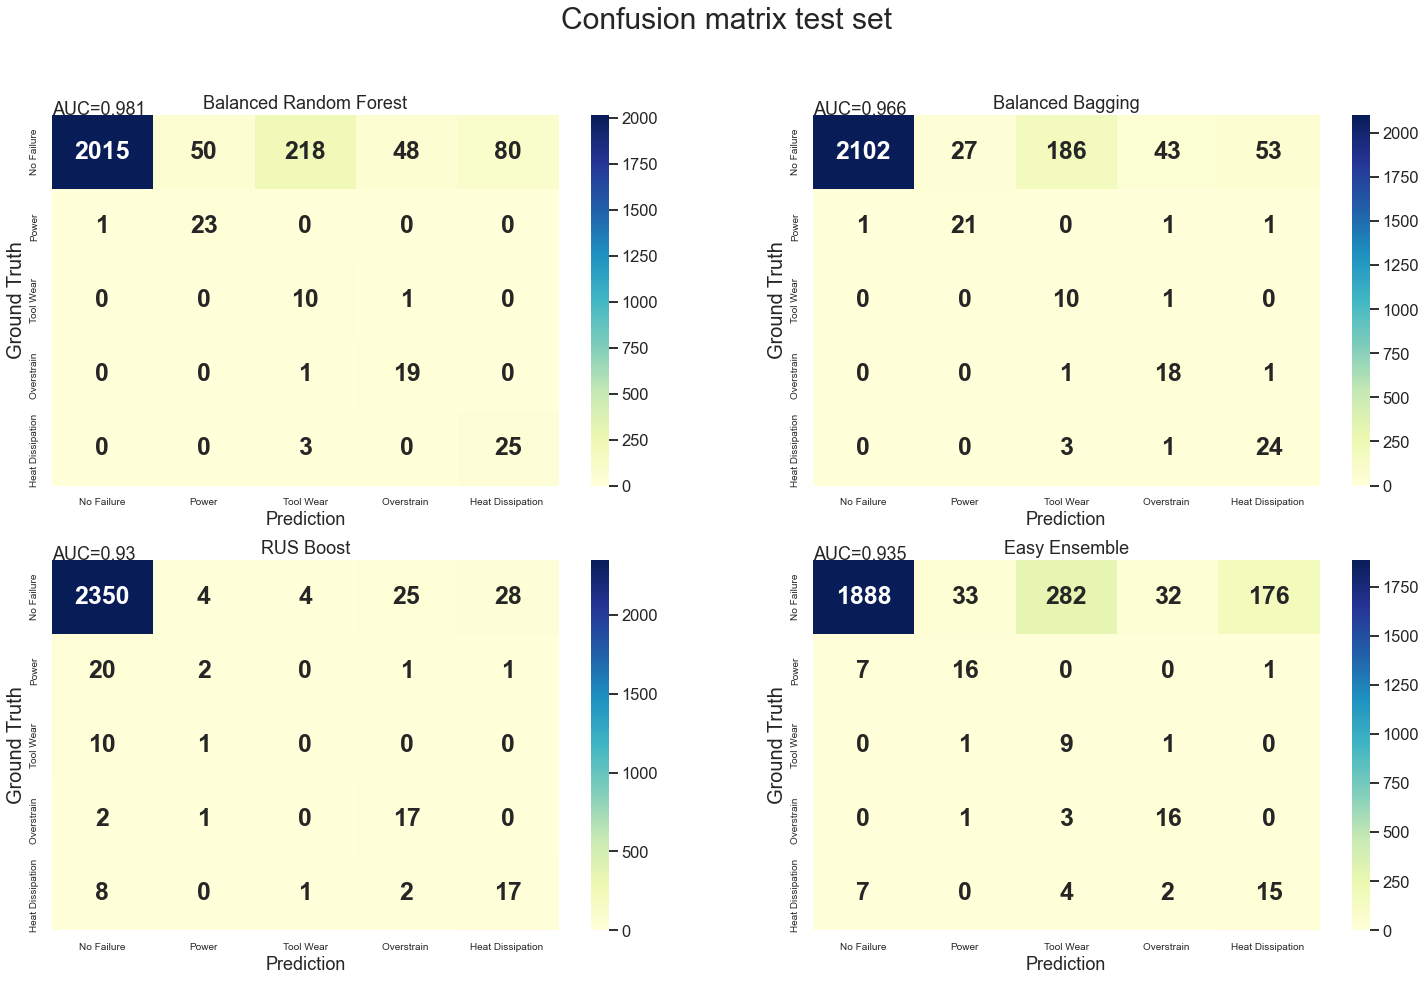

In [55]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)
bbc = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
RUSB = RUSBoostClassifier(random_state=42)
EEC = EasyEnsembleClassifier(random_state=42)

fig, axes = plt.subplots(2, 2, figsize=[25,15])
fig.suptitle('Confusion matrix test set', fontsize=30)
# axes.flatten()
i=0
j=0
for model in [brfc, bbc, RUSB, EEC]:
    print('Fitting', model)
    model = model.fit(X_train, y_train)

    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25)
    
    y_pred = model.predict(X_test)
    y_preb_probs = model.predict_proba(X_test)

    print(f'ROC AUC test set: {roc_auc_score(y_test, y_preb_probs, average="macro", multi_class="ovr")}')

    print()
    
    if j == 2:
        j = 0
        i = 1
        
    sns.set_context('talk')
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 25, "weight": "bold"}, ax=axes[i,j])

    labels =  ['No Failure',
               'Power',
               'Tool Wear',
               'Overstrain ',
               'Heat Dissipation ']
    axes[i,j].set_xticklabels(labels, fontsize=10);
    axes[i,j].set_yticklabels(labels, fontsize=10);
    axes[i,j].set_ylabel('Ground Truth', fontsize=20);
    axes[i,j].set_xlabel('Prediction')
    axes[i,j].annotate('AUC=' + str(round(roc_auc_score(y_test, y_preb_probs, average="macro", multi_class="ovr"),3)), xy=[0,0])
    j += 1

axes[0,0].set_title('Balanced Random Forest')
axes[0,1].set_title('Balanced Bagging')
axes[1,0].set_title('RUS Boost')
axes[1,1].set_title('Easy Ensemble')

Again, Balanced Random Forest and Balanced Bagging outpeformed the other two algorithms.

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Balanced Random Forest (Random Search) </span> 

In [56]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

params = {'n_estimators': np.arange(150, 400, 50),
               'max_depth': np.arange(10, 50, 10),
               'min_samples_split': [2, 4, 6],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 3, 4],
               'max_features': ['sqrt', 'log2']
            }

random_search = RandomizedSearchCV(brfc, params, cv=3,
                                   n_iter=100, random_state=42, n_jobs=-1)

random_search = random_search.fit(X_train, y_train)

# Best parameters from random search
print(random_search.best_params_)

{'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}


<span style="color:#26488F; font-size:18px; font-weight: bold;">  Balanced Random Forest (Grid Search) </span>

In [57]:
brfc = BalancedRandomForestClassifier(max_features='sqrt', random_state=42, n_jobs=-1)

params = {'n_estimators': [50, 100, 150],
               'max_depth': [15, 20, 25],
               'min_samples_leaf': [1, 2]
            }

grid_search = GridSearchCV(brfc, params, cv=cv,
                           n_jobs=-1)

grid_search = grid_search.fit(X_train, y_train)
# Best parameters from grid search
grid_search.best_params_

{'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 150}

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Training both models with the best hyperparameters </span>

In [58]:
# Balanced Random Forest
brfc = BalancedRandomForestClassifier(n_estimators=150, max_depth=15, min_samples_leaf=1,
                                     max_features='sqrt', random_state=42, n_jobs=-1)

brfc = brfc.fit(X_train, y_train)
y_pred_brfc = brfc.predict(X_test)
y_pred_probs_brfc = brfc.predict_proba(X_test)

# Balanced Bagging
bbc = BalancedBaggingClassifier(n_estimators=13, random_state=42, n_jobs=-1)
bbc = bbc.fit(X_train, y_train)
y_pred_bbc = bbc.predict(X_test)
y_pred_probs_bbc = bbc.predict_proba(X_test)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Scores </span>

In [59]:
# Balanced Random Forest scores
print('Results for Balanced Random Forest')
print(classification_report(y_test, y_pred_brfc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_brfc, average="macro", multi_class="ovr"))
print('='*53)
print()

# Balanced Bagging scores
print('Results for Balanced Bagging')
print(classification_report(y_test, y_pred_bbc))
print('Macro roc auc (OvR): ', roc_auc_score(y_test, y_pred_probs_bbc, average="macro", multi_class="ovr"))

Results for Balanced Random Forest
              precision    recall  f1-score   support

         0.0       1.00      0.84      0.91      2411
         1.0       0.30      0.96      0.46        24
         2.0       0.04      0.91      0.08        11
         3.0       0.28      0.95      0.43        20
         4.0       0.24      0.89      0.38        28

    accuracy                           0.84      2494
   macro avg       0.37      0.91      0.45      2494
weighted avg       0.97      0.84      0.89      2494

Macro roc auc (OvR):  0.9817419013652857

Results for Balanced Bagging
              precision    recall  f1-score   support

         0.0       1.00      0.87      0.93      2411
         1.0       0.47      0.96      0.63        24
         2.0       0.05      0.91      0.09        11
         3.0       0.31      0.90      0.46        20
         4.0       0.28      0.82      0.41        28

    accuracy                           0.87      2494
   macro avg       0.42  

**Conclusion:** Balance Random Forest has a higher ROC AUC (OvR) but a slightly lower f1 score (both macro and weighted).
Let's take a look at the decision matrices:

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Confusion matrix </span>

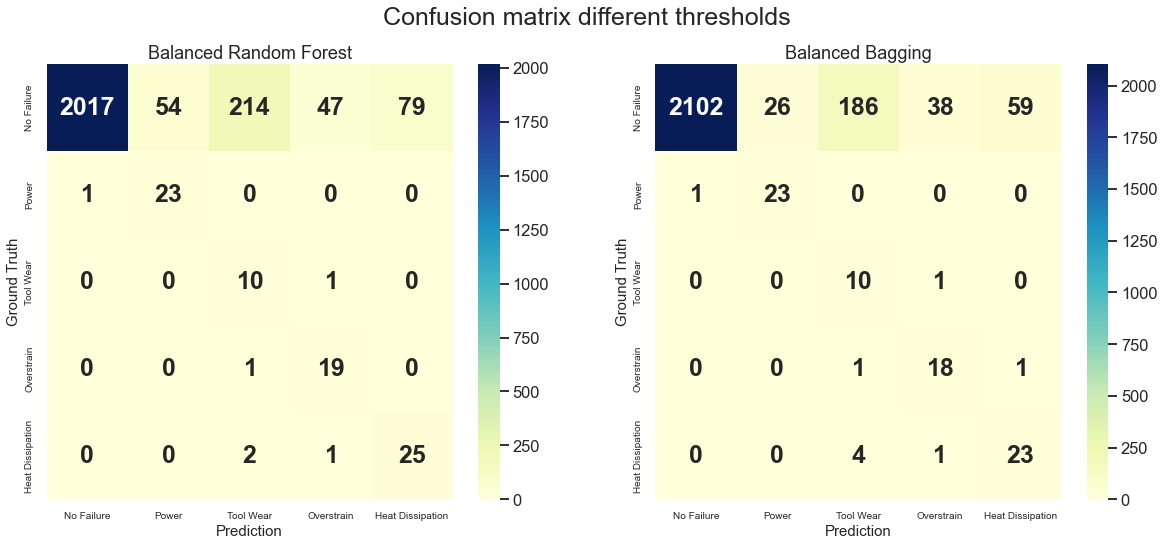

In [60]:
cm_brfc = confusion_matrix(y_test, y_pred_brfc)
cm_bbc = confusion_matrix(y_test, y_pred_bbc)

# Plotting confusion matrices
fig, ax = plt.subplots(1,2,figsize=(20,8))
ax.flatten()
fig.suptitle('Confusion matrix different thresholds', fontsize=25)

sns.heatmap(cm_brfc, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 25, "weight": "bold"}, ax=ax[0])
sns.heatmap(cm_bbc, annot=True, fmt='d', cmap='YlGnBu', annot_kws={"size": 25, "weight": "bold"}, ax=ax[1])

ax[0].set_title('Balanced Random Forest')
ax[1].set_title('Balanced Bagging')

labels =  ['No Failure',
           'Power',
           'Tool Wear',
           'Overstrain',
           'Heat Dissipation']

for i in [0,1]:
    ax[i].set_xticklabels(labels, fontsize=10);
    ax[i].set_yticklabels(labels, fontsize=10);
    ax[i].set_ylabel('Ground Truth', fontsize=15);
    ax[i].set_xlabel('Prediction', fontsize=15)

<span style="color:#26488F; font-size:18px; font-weight: bold;">  Conclusions </span>

The performance of both models are really close to each other. 
* There is a bit of a tendecy to missclasify Heat Dissipation Failure as Tool Wear Failure.
* For both models, only one failure was not correctly classfied.

Myself I would pick Balanced Bagging classifier for the following reasons:
* The recall scores are a slighty lower. But, we can see in the confusion matrix that the precision for each class is higher.
* Since we know that sometimes Heat Dissipation Failures are classifed as Tool Wear Failures, we might take the aproppiate actions to deal with such maintenance in the real world application. In other words, if we predict a Heat Dissipation Failure, we might check the tool wear as well.
* However, such decision should be supported by the maitenance team. It is difficult to pick without taking into account the real application.

<span style="color:#26488F; font-size:22px; font-weight: bold;">  Save Model </span>

In [61]:
with open("Pickle files/BalBagging_Multiclass.pkl","wb") as files:
    pickle.dump(bbc,files)